In [1]:
import pulp
import networkx as nx

# Data

In [2]:
sommets = [v for v in range(1,9)]
aretes = [(1, 2),(1, 3),(1, 7),(2, 3),(2, 4),(2, 5),(2, 7),(2, 8),(3, 4),(7, 6),(7, 8),(4, 5),(5, 6),(5, 8),(8, 6)]
poids = [6,7,4,4,9,9,10,5,4,12,11,6,8,7,14]
aretes = dict(zip(aretes,poids))

In [3]:
G=nx.Graph()
for (u,v) in aretes:
    G.add_edge(u,v,cost=aretes[(u,v)])

In [4]:
G.edges(data=True)

EdgeDataView([(1, 2, {'cost': 6}), (1, 3, {'cost': 7}), (1, 7, {'cost': 4}), (2, 3, {'cost': 4}), (2, 4, {'cost': 9}), (2, 5, {'cost': 9}), (2, 7, {'cost': 10}), (2, 8, {'cost': 5}), (3, 4, {'cost': 4}), (7, 6, {'cost': 12}), (7, 8, {'cost': 11}), (4, 5, {'cost': 6}), (5, 6, {'cost': 8}), (5, 8, {'cost': 7}), (8, 6, {'cost': 14})])

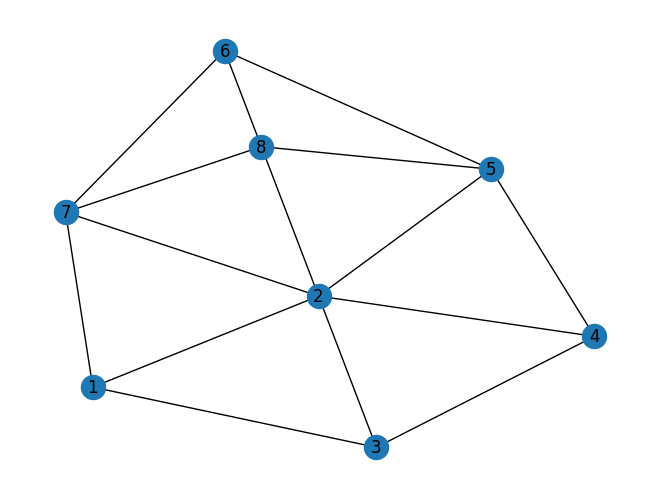

In [5]:
nx.draw(G,with_labels=True)

# Kruskal

In [6]:
T = nx.minimum_spanning_tree(G,weight="cost")

In [7]:
sorted(T.edges(data=True))

[(1, 2, {'cost': 6}),
 (1, 7, {'cost': 4}),
 (2, 3, {'cost': 4}),
 (2, 8, {'cost': 5}),
 (3, 4, {'cost': 4}),
 (4, 5, {'cost': 6}),
 (5, 6, {'cost': 8})]

In [8]:
sum(G[u][v]["cost"] for (u,v) in sorted(T.edges()))

37

# MIP1

In [59]:
# déclaration du problème
prob=pulp.LpProblem("tree",pulp.LpMinimize)

# variables
x=pulp.LpVariable.dicts("x",G.edges(),cat=pulp.LpBinary)

# objectif
prob += pulp.lpSum(x[(i,j)]*G[i][j]["cost"] for (i,j) in x)

# n-1 edges
prob += pulp.lpSum(x)==len(G.nodes())-1

# no cycles
for S in pulp.allcombinations(list(G.nodes()),len(G.nodes())):
    if len(S)>1:
        prob += pulp.lpSum(x[(u,v)] for u in S for v in S if (u,v) in x) <= len(S)-1

In [41]:
#for S in pulp.allcombinations(list(G.nodes()),len(G.nodes())):
#    if len(S)>2:
#        print(S,":",pulp.lpSum(x[(u,v)] for u in S for v in S if (u,v) in x),"<=", len(S)-1)

In [60]:
#prob

In [61]:
prob.solve()

1

In [62]:
pulp.value(prob.objective)

37.0

In [63]:
for (i,j) in x:
    if pulp.value(x[(i,j)])>0.9:
        print((i,j),G[i][j]["cost"])

(1, 2) 6
(1, 7) 4
(2, 3) 4
(2, 8) 5
(3, 4) 4
(4, 5) 6
(5, 6) 8


# MIP 2

In [10]:
H=G.to_directed()

In [11]:
H.edges(data=True)

OutEdgeDataView([(1, 2, {'cost': 6}), (1, 3, {'cost': 7}), (1, 7, {'cost': 4}), (2, 1, {'cost': 6}), (2, 3, {'cost': 4}), (2, 4, {'cost': 9}), (2, 5, {'cost': 9}), (2, 7, {'cost': 10}), (2, 8, {'cost': 5}), (3, 1, {'cost': 7}), (3, 2, {'cost': 4}), (3, 4, {'cost': 4}), (7, 1, {'cost': 4}), (7, 2, {'cost': 10}), (7, 6, {'cost': 12}), (7, 8, {'cost': 11}), (4, 2, {'cost': 9}), (4, 3, {'cost': 4}), (4, 5, {'cost': 6}), (5, 2, {'cost': 9}), (5, 4, {'cost': 6}), (5, 6, {'cost': 8}), (5, 8, {'cost': 7}), (8, 2, {'cost': 5}), (8, 7, {'cost': 11}), (8, 5, {'cost': 7}), (8, 6, {'cost': 14}), (6, 7, {'cost': 12}), (6, 5, {'cost': 8}), (6, 8, {'cost': 14})])

In [12]:
L=[]
for (u,v) in H.edges():
    if v==1:
        L.append((u,v))
H.remove_edges_from(L)

In [13]:
# déclaration du problème
prob=pulp.LpProblem("tree",pulp.LpMinimize)

# variables
x=pulp.LpVariable.dicts("x",H.edges(),cat=pulp.LpBinary)
u=pulp.LpVariable.dicts("u",H.nodes(),lowBound=0,upBound=len(H.nodes())-1,cat=pulp.LpInteger)

# objectif
prob += pulp.lpSum(x[(i,j)]*H[i][j]["cost"] for (i,j) in x)

prob += pulp.lpSum(x[(1,j)] for j in H.nodes() if (1,j) in x)>=1
for j in H.nodes():
    if j>1:
        prob += pulp.lpSum(x[(i,j)] for i in H.nodes() if (i,j) in x)==1
for (i,j) in H.edges():
    if j>1:
        prob += u[i]+1-u[j]<=len(H.nodes())*(1-x[(i,j)])

In [14]:
#prob

In [15]:
prob.solve()

1

In [16]:
pulp.value(prob.objective)

37.0

In [17]:
for (i,j) in x:
    if pulp.value(x[(i,j)])>0.9:
        print((i,j),H[i][j]["cost"])

(1, 2) 6
(1, 7) 4
(2, 3) 4
(2, 8) 5
(3, 4) 4
(4, 5) 6
(5, 6) 8


# MIP 3

In [27]:
# déclaration du problème
prob=pulp.LpProblem("tree",pulp.LpMinimize)

# variables
x=pulp.LpVariable.dicts("x",H.edges(),cat=pulp.LpBinary)
f=pulp.LpVariable.dicts("f",H.edges(),lowBound=0,upBound=None,cat=pulp.LpContinuous)

# objectif
prob += pulp.lpSum(x[(i,j)]*H[i][j]["cost"] for (i,j) in x)

# optional
#prob += pulp.lpSum(x)==len(H.nodes())-1

prob += pulp.lpSum(f[(1,j)] for j in H.nodes() if (1,j) in f)==len(H.nodes())-1
for j in H.nodes():
    if j>1:
        prob += pulp.lpSum(f[(i,j)] for i in H.nodes() if (i,j) in f)==pulp.lpSum(f[(j,i)] for i in H.nodes() if (j,i) in f)+1
for (i,j) in H.edges():
    prob +=f[(i,j)]<=(len(H.nodes())-1)*(x[(i,j)])

In [28]:
prob.solve()

1

In [29]:
#prob

In [30]:
pulp.value(prob.objective)

37.0

In [31]:
for (i,j) in x:
    if pulp.value(x[(i,j)])>0.9:
        print((i,j),H[i][j]["cost"])

(1, 2) 6
(1, 7) 4
(2, 3) 4
(2, 8) 5
(3, 4) 4
(4, 5) 6
(5, 6) 8
